## Setup

In [1]:
import pandas as pd

# Get data
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
data = pd.concat((train, test), sort=False)

## Explore Data

In [2]:
#train.describe()
#test.describe()
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Survived       891 non-null float64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [4]:
print('N/A train')
print(train.isnull().sum())

print('\nN/A test')
print(test.isnull().sum())

N/A train
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

N/A test
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


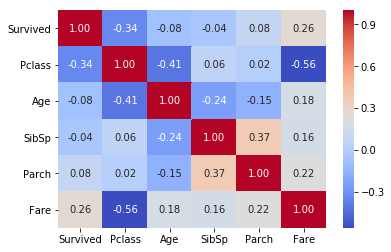

In [5]:
import seaborn as sb

numeric_data = data.drop('PassengerId', axis=1).select_dtypes(include=['number'])
sb.heatmap(numeric_data.corr(), annot=True,fmt='.2f',cmap ='coolwarm')

## Preprocessing

In [6]:
X_train = train.select_dtypes(include=['number']).drop(['PassengerId', 'Survived'], axis=1)
y_train = train['Survived']
X_test = test.select_dtypes(include=['number']).drop('PassengerId', axis=1).copy()

X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_train.mean(), inplace=True)

## Fit / Predict

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

model_instances = [DecisionTreeClassifier(), GaussianNB(), LogisticRegression(solver='lbfgs'), RandomForestClassifier(n_estimators=100)]

In [8]:
def simple_score(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return 100 * model.score(X_train,y_train)

In [9]:
from sklearn.model_selection import cross_val_score

def cv_score(model, cv=10):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return 100 * cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy').mean()

## Evaluate

In [10]:
results = {'Model': [type(model).__name__ for model in model_instances],
           'Score': [simple_score(model) for model in model_instances],
           'CV_Score': [cv_score(model, 10) for model in model_instances]}

models_eval = pd.DataFrame(results)

In [11]:
models_eval.sort_values(by='Score',ascending=False)

,Model,Score,CV_Score
0,DecisionTreeClassifier,95.735129,65.219044
3,RandomForestClassifier,95.735129,69.604954
2,LogisticRegression,70.482604,70.276501
1,GaussianNB,68.686869,68.151714


In [12]:
models_eval.sort_values(by='CV_Score',ascending=False)

,Model,Score,CV_Score
2,LogisticRegression,70.482604,70.276501
3,RandomForestClassifier,95.735129,69.604954
1,GaussianNB,68.686869,68.151714
0,DecisionTreeClassifier,95.735129,65.219044


## Submit

In [13]:
best_model_name = models_eval['Model'][models_eval['CV_Score'].idxmax()]

for model in model_instances:
    if type(model).__name__ == best_model_name:
        y_pred = model.predict(X_test)
        break

submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_pred})
submission.to_csv('submission.csv',index=False)